In [1]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split

In [2]:
import torch

print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 2


In [3]:
!pip install ultralytics

In [4]:
!pip install -U ipywidgets

In [5]:
dataset_path = '/kaggle/input/car-plate-detection'

In [6]:
import re

def the_number_in_the_string(filename):
    """
    Extracts the first sequence of digits from the given filename string and returns it as an integer.
    If no digits are found, returns 0.

    Parameters:
    filename (str): The input string to search for digits.

    Returns:
    int: The first sequence of digits found in the input string, or 0 if no digits are found.
    """
    # Searching for the first occurrence of one or more digits in the filename
    match = re.search(r'(\d+)', filename)
    
    # If a match is found, returning the matched number as an integer
    if match:
        return int(match.group(0))
    else:
        return 0

print(the_number_in_the_string("Cars105.png")) 

105


In [7]:
labels_dict = dict(
    img_path=[], 
    x_min=[], 
    x_max=[], 
    y_min=[], 
    y_max=[], 
    img_w=[], 
    img_h=[]
)

xml_files = glob(f'{dataset_path}/annotations/*.xml')

for filename in sorted(xml_files, key=the_number_in_the_string):
    
    info = xet.parse(filename)
    root = info.getroot()
    
    # Finding the 'object' element in the XML and extracting bounding box information
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    x_min = int(labels_info.find('xmin').text)
    x_max = int(labels_info.find('xmax').text)
    y_min = int(labels_info.find('ymin').text)
    y_max = int(labels_info.find('ymax').text)

    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)

    labels_dict['img_path'].append(img_path)
    labels_dict['x_min'].append(x_min)
    labels_dict['x_max'].append(x_max)
    labels_dict['y_min'].append(y_min)
    labels_dict['y_max'].append(y_max)
    
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)
    
all_data = pd.DataFrame(labels_dict)

all_data.head()

,img_path,x_min,x_max,y_min,y_max,img_w,img_h
0,/kaggle/input/car-plate-detection/images/Cars0...,226,419,125,173,500,268
1,/kaggle/input/car-plate-detection/images/Cars1...,134,262,128,160,400,248
2,/kaggle/input/car-plate-detection/images/Cars2...,229,270,176,193,400,400
3,/kaggle/input/car-plate-detection/images/Cars3...,142,261,128,157,400,225
4,/kaggle/input/car-plate-detection/images/Cars4...,156,503,82,253,590,350


In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(all_data, test_size=1/10, random_state=42)

train, val = train_test_split(train, train_size=8/9, random_state=42)

print(f'''
      len(train) = {len(train)}
      len(val) = {len(val)}
      len(test) = {len(test)}
''')


      len(train) = 345
      len(val) = 44
      len(test) = 44



In [9]:
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [10]:
def make_split_folder_in_yolo_format(split_name, split_df):
    """
    Creates a folder structure for a dataset split (train/val/test) in YOLO format.

    Parameters:
    split_name (str): The name of the split (e.g., 'train', 'val', 'test').
    split_df (pd.DataFrame): The DataFrame containing the data for the split.

    The function will create 'labels' and 'images' subdirectories under 'datasets/cars_license_plate/{split_name}',
    and save the corresponding labels and images in YOLO format.
    """
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')

    os.makedirs(labels_path)
    os.makedirs(images_path)
    
    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))

        x_center = (row['x_min'] + row['x_max']) / 2 / row['img_w']
        y_center = (row['y_min'] + row['y_max']) / 2 / row['img_h']
        width = (row['x_max'] - row['x_min']) / row['img_w']
        height = (row['y_max'] - row['y_min']) / row['img_h']

        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")
            
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))
    
    print(f"Created '{images_path}' and '{labels_path}'")

In [11]:
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

Created 'datasets/cars_license_plate_new/train/images' and 'datasets/cars_license_plate_new/train/labels'
Created 'datasets/cars_license_plate_new/val/images' and 'datasets/cars_license_plate_new/val/labels'
Created 'datasets/cars_license_plate_new/test/images' and 'datasets/cars_license_plate_new/test/labels'


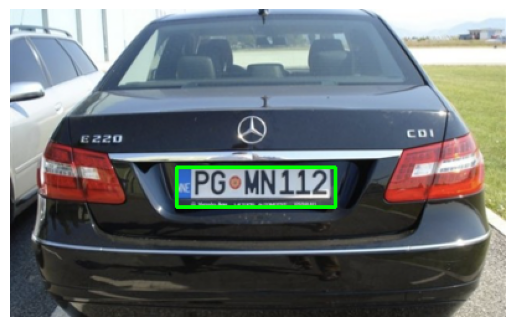

In [13]:
image_dir = 'datasets/cars_license_plate_new/train/images'
label_dir = 'datasets/cars_license_plate_new/train/labels'

image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

image = cv2.imread(image_path)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

with open(label_path, 'r') as f:
    lines = f.readlines()

for line in lines:
    
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(image)
plt.axis('off') 
plt.show() 

In [12]:
datasets_yaml = '''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)